In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [244]:
patient_gene_proj_scores = pd.read_table("../data/processed/allsamples_gene_variability_scores.csv", sep=",")
patient_gene_proj_scores.set_index("patient_id", inplace=True)

In [322]:
training_proj_df = pd.read_table("../data/processed/training_pca_projs.csv", sep=",", 
                                    index_col="patient_id")
valid_proj_df = pd.read_table("../data/processed/validation_pca_projs.csv", sep=",", 
                                    index_col="patient_id")
all_projs = pd.concat([training_proj_df, valid_proj_df], axis=0)

In [323]:
sample_cluster = np.load("../data/interim/new_kmeans_membership_5clusters.npy")
# sample_cluster.set_index("patient_id", inplace=True)
sample_cluster = pd.Series(sample_cluster, index=pca_projs_concat_df.index, name="cluster")

# Predict Cluster from Gene Scores with Logistic Regression

In [293]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [295]:
lr = LogisticRegressionCV(Cs=5, cv=5, penalty="l1", 
                          l1_ratios=np.arange(0, 1, 0.2),
                        solver="saga",
                        multi_class="ovr", n_jobs=4)
print(lr.fit(all_projs, sample_cluster))

/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1992: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  self.penalty))
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means

LogisticRegressionCV(Cs=5, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=array([0. , 0.2, 0.4, 0.6, 0.8]), max_iter=100,
                     multi_class='ovr', n_jobs=4, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol=0.0001, verbose=0)


In [297]:
lr.score(all_projs, sample_cluster)

1.0

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

scores = cross_val_score(lr, patient_gene_proj_scores, sample_cluster, cv=5, 
                         scoring="f1_micro")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# gene variability score with Logistic Regression

IndexError: index 382 is out of bounds for axis 0 with size 53

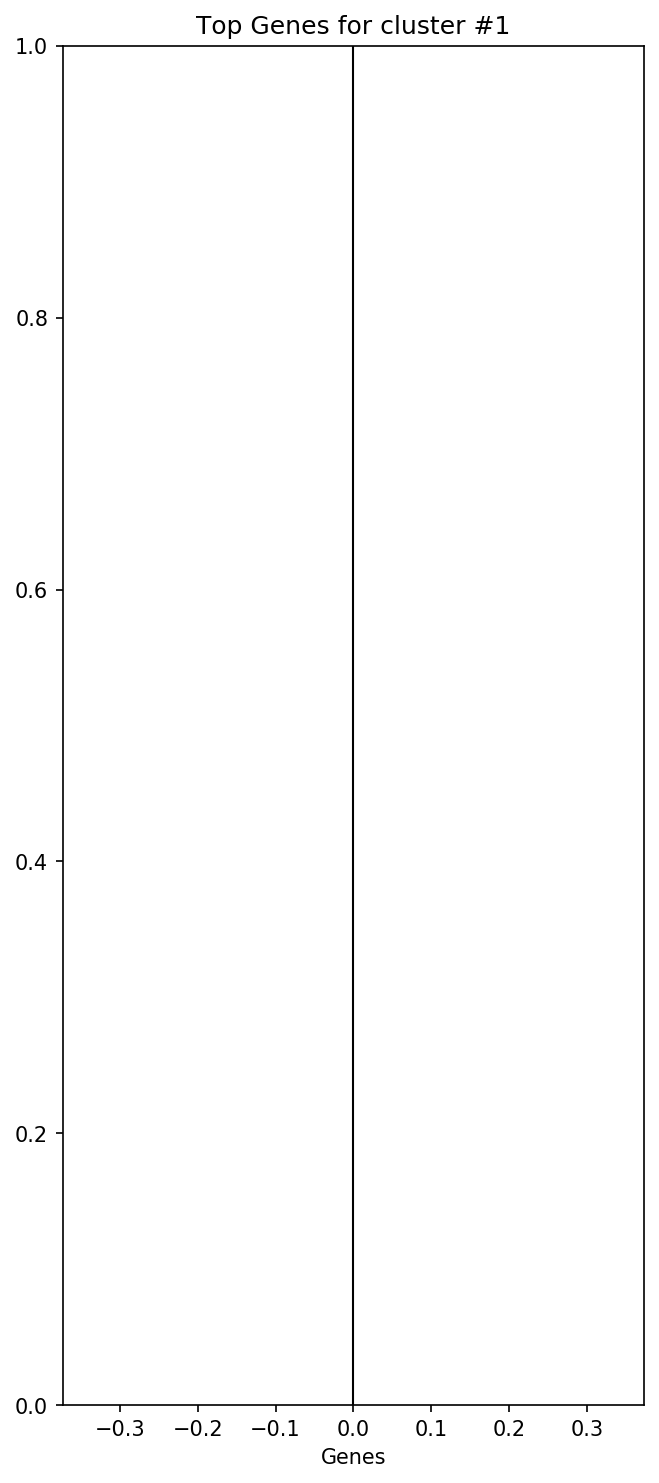

In [298]:
for cluster in range(lr.coef_.shape[0]):
    fig = plt.figure(figsize=(5, 12), dpi=150)
    genes_ordered = np.argsort(lr.coef_[cluster])
    ax = fig.add_subplot(111)
    ax.set_title("Top Genes for cluster #{}".format(cluster+1))
    ax.set_xlabel("Genes")
    ax.axvline(0, color='k', lw=1)
#     ax.spines['bottom'].set_position('center')
#     plt.xticks(rotation=90)
    abs_max = max(np.abs(lr.coef_[cluster]))+0.25
    ax.set_xlim((-abs_max, abs_max))
    ax.barh(y=patient_gene_proj_scores.columns[genes_ordered], 
            width=lr.coef_[cluster][genes_ordered],
            align='center')

# Clustering centroids

In [332]:
gene_proj_scores_by_cluster = patient_gene_proj_scores.join(sample_cluster)
gene_proj_scores_cluster_means = gene_proj_scores_by_cluster.groupby("cluster").agg("mean")
gene_center_mean = patient_gene_proj_scores.mean(axis=0)

In [333]:
gene_proj_scores_cluster_means

,BANK1,BIK,BLK,BTNL2,CDHR5,CEP70,CHD7,CNTNAP2,DAP,DAPK1,...,TNFAIP3,TNFRSF13B,TNFSF4,TNIP1,TNPO3,TSPO,TTLL12,TYK2,UBE2L3,XKR6
cluster,,,,,,,,,,,,,,,,,,,,,
1,7.792865,1.745345,9.891564,12.381827,0.545463,2.088583,11.201281,3.700470,7.149090,6.944214,...,3.176887,2.919495,4.709687,5.196686,3.961406,1.744295,8.561609,2.128416,2.722893,10.476668
2,8.083323,1.706299,7.762504,11.496376,0.623554,2.153789,9.824608,3.554477,8.382987,8.205941,...,3.609515,2.684842,4.756345,5.436955,3.543400,2.105313,8.439875,2.003782,2.720374,9.643516
3,7.862255,1.761966,8.907028,10.779911,0.624756,1.994272,9.190967,3.730435,7.513917,7.334537,...,3.156317,2.663057,4.519785,5.186083,3.516263,2.058334,8.447650,1.998738,2.604823,10.861087
4,7.913469,1.689339,8.931944,14.173990,0.639062,2.072222,8.331421,3.659051,8.002382,7.883604,...,3.272113,3.031350,4.816600,5.181682,3.478815,2.136508,8.356462,1.857176,2.948668,9.930127
5,8.020982,1.792708,8.275405,11.105666,0.640976,1.910320,8.774971,3.924287,8.108785,8.046201,...,3.187913,2.899496,4.751482,5.000122,3.504762,2.162839,8.960007,2.065649,2.841137,10.101546


In [331]:
# gene_cluster_diff_agg = pd.DataFrame(index=range(5), columns=patient_gene_proj_scores.columns)
# for cluster in gene_cluster_diff_agg.index:
#     gene_proj_agg[cluster] = pd.
#     for gene in gene_proj_scores_cluster_means.columns:
#         gene_diff = gene_proj_scores_cluster_means - gene_center_mean
#         for proj in gene_proj_scores_cluster_means.columns:
# gene_cluster_diff_agg

In [350]:
np.where(np.core.defchararray.find(gene_score_diff.index.tolist(), "HLA")!=-1)
# gene_score_diff[gene_score_diff.indexz]

(array([15, 16, 17, 18, 19, 20, 21, 22]),)

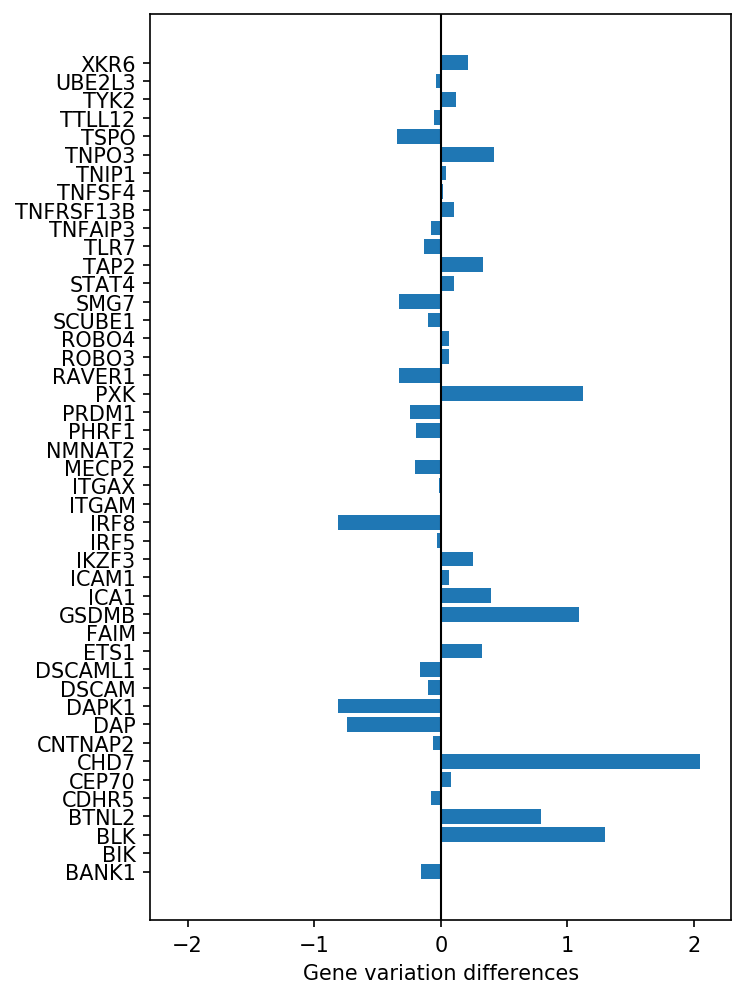

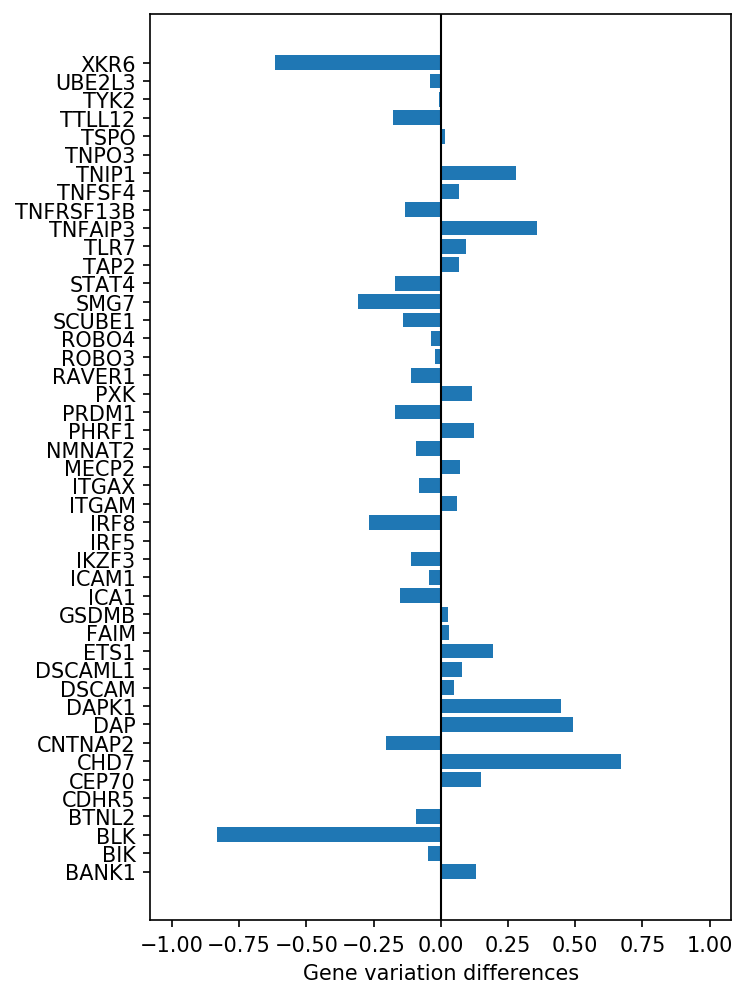

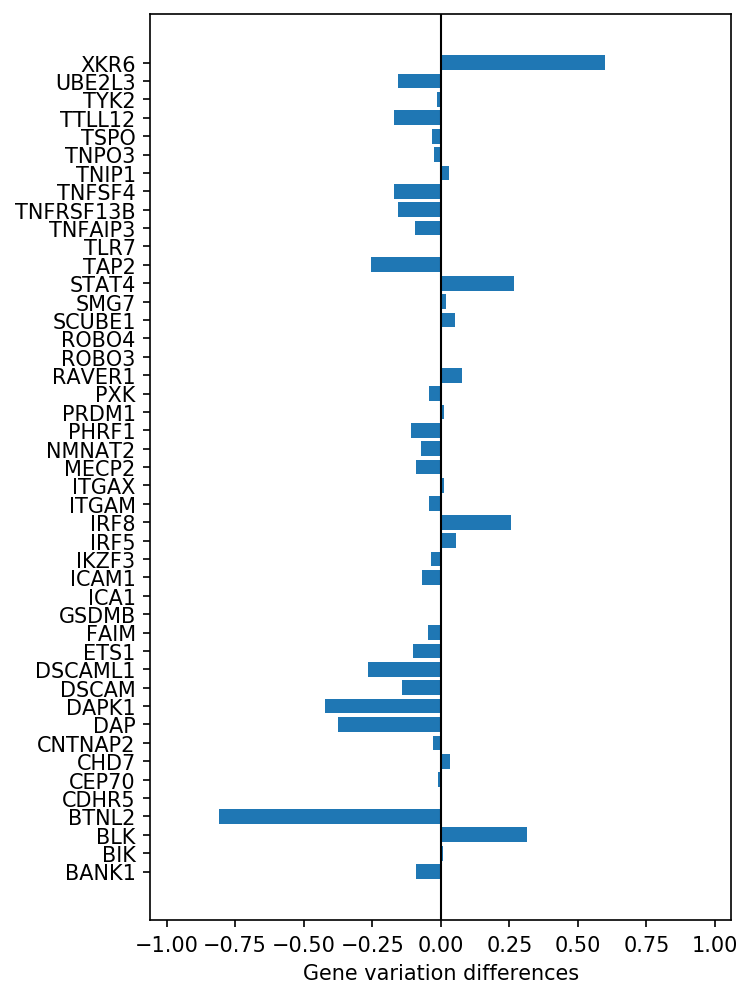

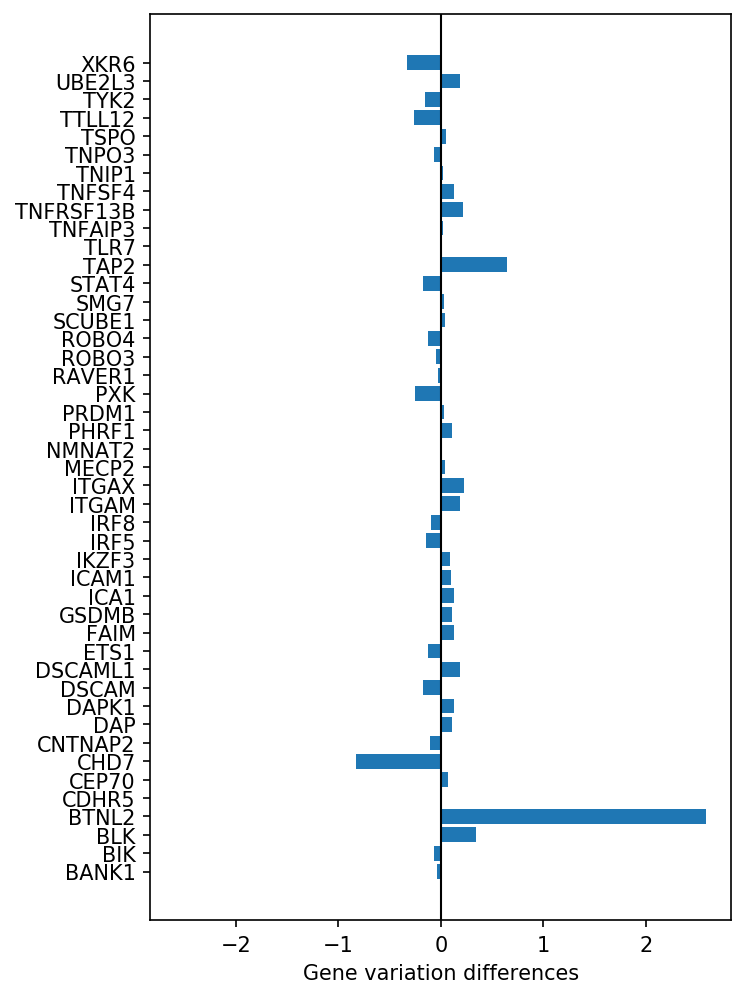

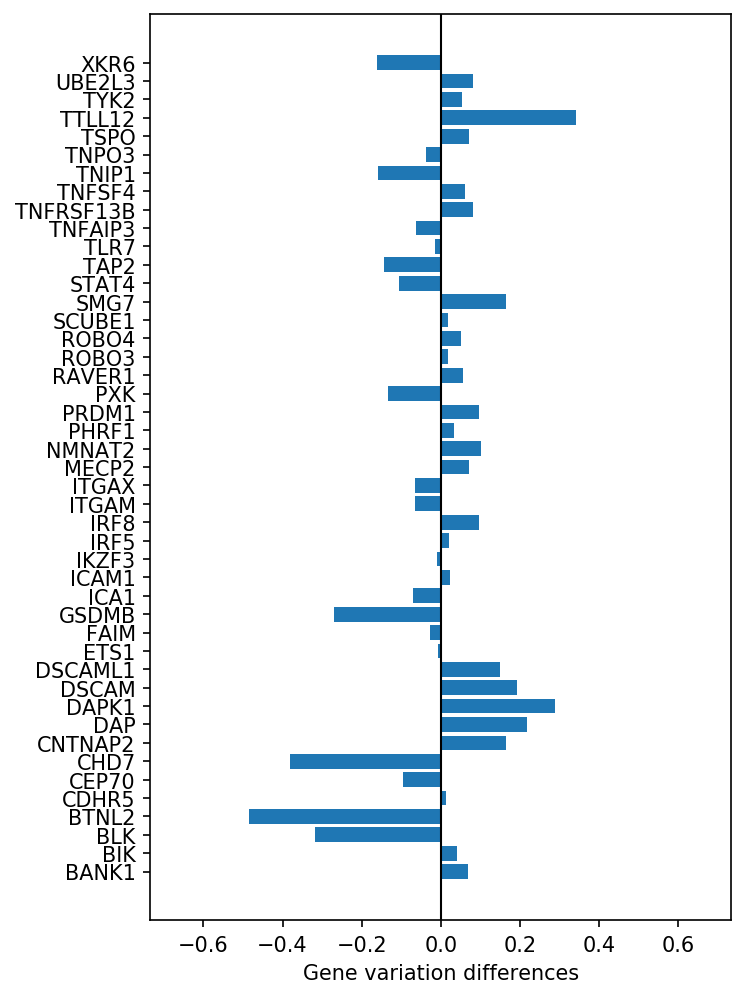

In [365]:
for cluster in range(gene_proj_scores_cluster_means.shape[0]):
    gene_score_diff = gene_proj_scores_cluster_means.iloc[cluster] - gene_center_mean
    fig = plt.figure(figsize=(5, 8), dpi=150)
    genes_ordered = np.where(np.core.defchararray.find(gene_score_diff.index.tolist(), "HLA")==-1)[0]
#     genes_ordered = np.argsort(gene_score_diff)
    ax = fig.add_subplot(111)
#     ax.set_title("Composition of cluster #{}".format(cluster+1))
#     ax.set_xlabel("Genes")
    ax.set_xlabel("Gene variation differences")
    ax.axvline(0, color='k',lw=1)   # poor man's zero level
    abs_max = max(np.abs(gene_score_diff[genes_ordered]))+0.25
    ax.set_xlim((-abs_max, abs_max))
    ax.barh(y=gene_score_diff.index[genes_ordered], 
            width=gene_score_diff[genes_ordered],
           align='center')

# Cosine similarity between genes by variability

In [316]:
gene_cov = patient_gene_proj_scores.corr()

In [317]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=6)
gene_cluster = sc.fit_predict(gene_cov)
gene_cluster_sorted = np.argsort(gene_cluster)

/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


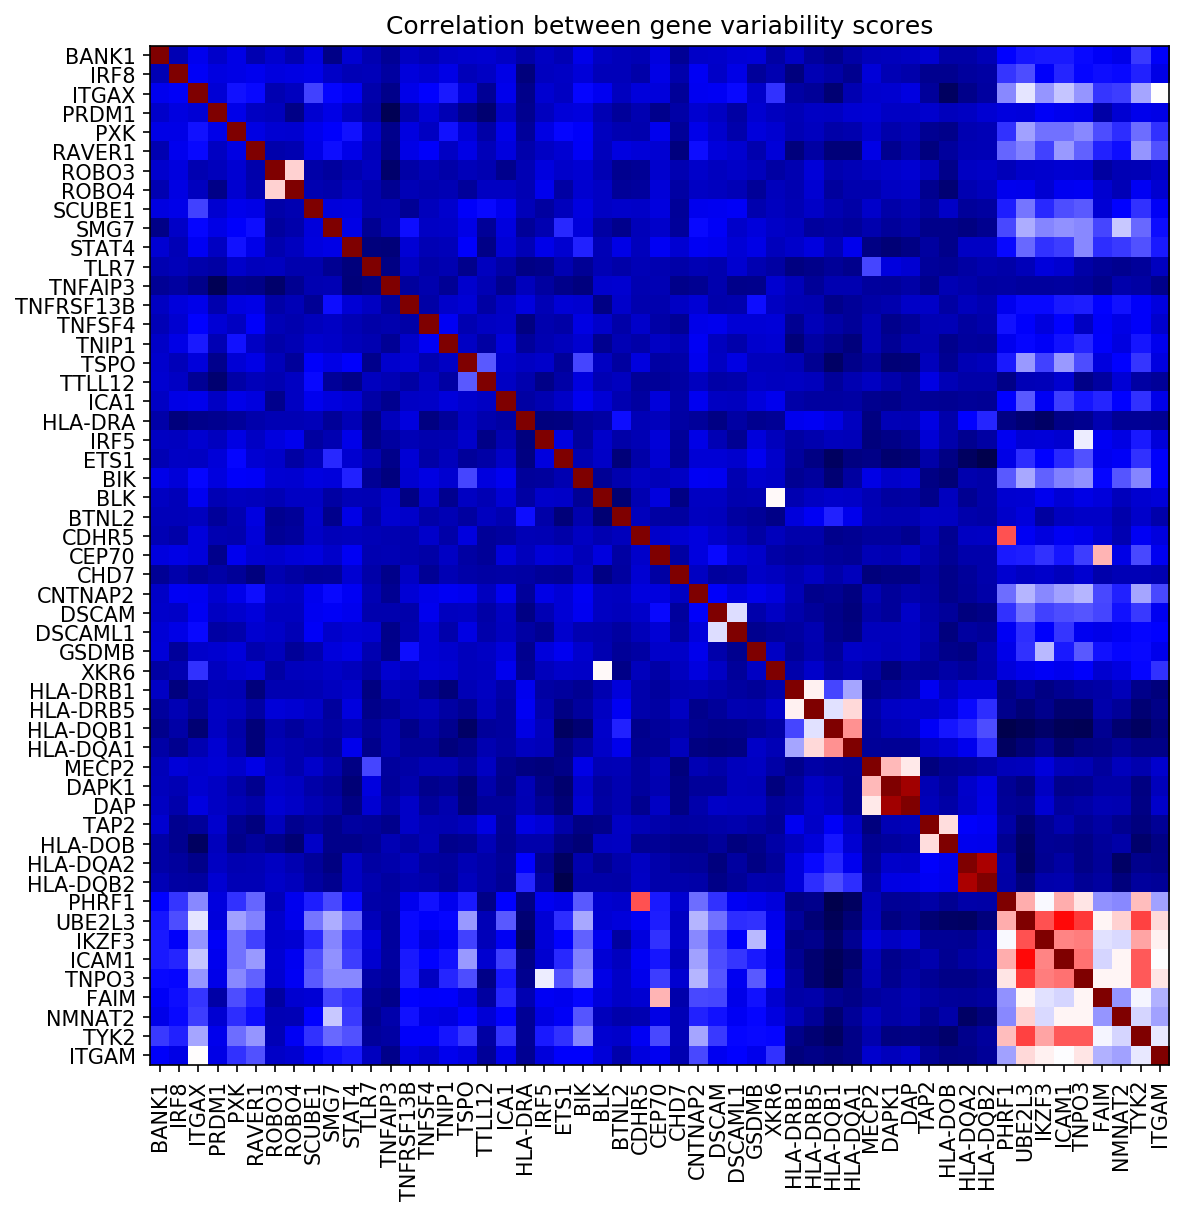

In [319]:
fig, ax = plt.subplots(figsize=(9,9), dpi=150)
genes_list = gene_cov.index[gene_cluster_sorted]
ax.set_title("Correlation between gene variability scores")
ax.set_xticks(np.arange(len(genes_list)))
ax.set_yticks(np.arange(len(genes_list)))
ax.set_xticklabels(genes_list, rotation=90)
ax.set_yticklabels(genes_list)
im = ax.imshow((gene_cov+0.6).iloc[gene_cluster_sorted.tolist(), gene_cluster_sorted.tolist()], cmap="seismic")